In [1]:
library(Matrix)
library(dplyr)
library(rjson)
library(Seurat)
library(ggplot2)
#library(SeuratDisk)
library(Matrix)
#library(SpaceX)
library(cowplot)
library(patchwork)
library(tidyr)
# co-expression network analysis packages:
library(WGCNA)
library(hdWGCNA)
#library(SeuratData)
library(igraph)
library(Matrix)
enableWGCNAThreads(nThreads = 48)
library(magrittr)
library(purrr)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching SeuratObject

‘SeuratObject’ was built with package ‘Matrix’ 1.6.3 but the current
version is 1.6.5; it is recomended that you reinstall ‘SeuratObject’ as
the ABI for ‘Matrix’ may have changed

Seurat v4 was just loaded with SeuratObject v5; disabling v5 assays and
validation routines, and ensuring assays work in strict v3/v4
compatibility mode


Attaching package: ‘patchwork’


The following object is masked from ‘package:cowplot’:

    align_plots



Attaching package: ‘tidyr’


The following objects are masked from ‘package:Matrix’:

    expand, pack, unpack


Loading required package: dynamicTreeCut

Loading required package: fastcluster


Attaching package: ‘fastcluster’


The following object is masked from ‘package:stats’:

    hclust





Attaching package: ‘WGCNA’


The

Allowing parallel execution with up to 48 working processes.



Attaching package: ‘magrittr’


The following object is masked from ‘package:tidyr’:

    extract



Attaching package: ‘purrr’


The following object is masked from ‘package:magrittr’:

    set_names


The following objects are masked from ‘package:igraph’:

    compose, simplify




In [2]:
# read the matrix
matrix = readMM("../Result/Concentric_to_R/concentric_outer3_all.mtx")

# read the cell and gene names
meta = read.csv("../Result/Concentric_to_R/outer3_meta_data.csv")
feature_name = read.csv("../Result/Concentric_to_R/outer3_raw_feature.csv")

rownames(matrix) = meta$barcode
colnames(matrix) = feature_name$X

meta_info = read.csv("../Result/Concentric_to_R/outer3_meta_data.csv")

data = CreateSeuratObject(counts = t(matrix), project = "pbmc3k", min.cells = 0, min.features = 0)

# add the meta information
for (i in meta_info){
    for (i in colnames(meta_info)){
        data[[i]] = meta_info[[i]]
    }
}

meta_info = read.csv("../Result/Concentric_to_R/meta_data.csv")

meta_sub = meta_info[,c("barcode", "concentric")]

meta_all = data@meta.data
meta_all$concentric = NULL

meta_df <- merge(meta_all, meta_sub, by = "barcode", all.x = TRUE)

sub = subset(meta_df, annotation == "Ex" & levels == "severe" & concentric == "inner")

meta_df$concentric[is.na(meta_df$concentric)] <- "outer3"

for (i in meta_df){
    for (i in colnames(meta_df)){
        data[[i]] = meta_df[[i]]
    }
}

In [3]:
# only use the inner and outer2
data = subset(data, subset = concentric == "inner" | concentric == "outer2" | concentric == "outer")

In [4]:
data <-  data %>%
  FindVariableFeatures() %>%
  ScaleData() %>%
  RunPCA()

Centering and scaling data matrix

PC_ 1 
Positive:  KCNIP4, SNHG14, CSMD1, NRG3, SLCO5A1, DPP10, HFM1, CXCL14, MALAT1, LRP1B 
	   ERBB4, CLDN5, AC098650.1, FLT1, SLC1A2, GPC5, HBB, TM4SF1, TNFSF10, AC123769.1 
	   FGR, SMOC2, AC008083.1, FOXC2, SLPI, AC004597.1, ADGRV1, TM4SF19-AS1, AL136164.3, IFI44L 
Negative:  PLP1, TF, CLDND1, CRYAB, CNP, SCD, QDPR, MAG, SPP1, SELENOP 
	   QKI, GPRC5B, GPM6B, SLC44A1, PTGDS, ANLN, ST18, PRR18, CTNNA3, TMTC2 
	   DOCK5, GLUL, FRMD4B, PCDH9, IL1RAPL1, AC026316.5, B2M, C10orf90, NCKAP5, TCF12 
PC_ 2 
Positive:  SLC1A2, GJA1, SLC1A3, AQP4, ATP1A2, GLUL, APOE, PTGDS, CD81, PTN 
	   ADGRV1, ANGPTL4, GPC5, NPAS3, GPRC5B, CDH20, AL049839.2, NEAT1, ZBTB20, MEGF10 
	   AC119674.2, CXCL14, MAML2, AC093010.3, FBXL7, ERBB4, GPM6B, LRP1B, PCDH9, ARHGAP24 
Negative:  PLP1, QDPR, TF, MAG, SPP1, KCNIP4, IL1RAPL1, CLDND1, PTPRD, CNP 
	   ANLN, CSMD1, SLC44A1, SCD, SNHG14, CTNNA3, CRYAB, DLG2, ST18, SELENOP 
	   PRR18, FRMD4B, AC026316.5, HFM1, SHROOM4, KCNH8, SLC5A

In [5]:
data <- SetupForWGCNA(
  data,
  gene_select = "fraction",
  fraction = 0.05,
  wgcna_name = "vis"
)

In [6]:
data <- MetacellsByGroups(
  seurat_obj = data,
  group.by = c("annotation", "sample"), # specify the columns in seurat_obj@meta.data to group by
  reduction = 'pca', # select the dimensionality reduction to perform KNN on
  k = 10, # nearest-neighbors parameter
  max_shared = 10, # maximum number of shared cells between two metacells
  ident.group = 'annotation' # set the Idents of the metacell seurat object
)

Warning message in MetacellsByGroups(seurat_obj = data, group.by = c("annotation", :
“Removing the following groups that did not meet min_cells: Inh#A02092E1, Inh#B01809A3, Inh#B02008C6, Inh#B02008D2, Inh#D02175A4, Inh#D02175A6, Mic#B01809C2, Mic#B02008C6, Mic#B02008D2, Mic#D02175A4, Oli#D02175A4, Opc#B01809A3, Opc#B02008D2, Opc#D02175A4”


In [7]:
data <- NormalizeMetacells(data)

In [31]:
data <- SetDatExpr(
  data,
  group_name = "Ex", # the name of the group of interest in the group.by column
  group.by='annotation', # the metadata column containing the cell type info. This same column should have also been used in MetacellsByGroups
  assay = 'RNA', # using RNA assay
  slot = 'data', # using normalized data
  use_metacells = TRUE
)

In [32]:
# Test different soft powers
data<- TestSoftPowers(
  data,
  networkType = 'signed' # you can also use "unsigned" or "signed hybrid"
)

pickSoftThreshold: will use block size 1532.
 pickSoftThreshold: calculating connectivity for given powers...
   ..working on genes 1 through 1532 of 1532
   Power SFT.R.sq   slope truncated.R.sq  mean.k. median.k.   max.k.
1      1   0.8480  61.000          0.850 7.83e+02  7.82e+02 8.07e+02
2      2   0.8370  29.600          0.863 4.00e+02  4.00e+02 4.26e+02
3      3   0.8140  18.900          0.878 2.05e+02  2.04e+02 2.25e+02
4      4   0.7740  13.800          0.893 1.05e+02  1.05e+02 1.19e+02
5      5   0.7000  10.400          0.856 5.41e+01  5.36e+01 6.34e+01
6      6   0.5950   7.680          0.774 2.78e+01  2.75e+01 3.37e+01
7      7   0.4670   5.370          0.776 1.43e+01  1.41e+01 1.79e+01
8      8   0.3430   3.930          0.677 7.39e+00  7.26e+00 9.57e+00
9      9   0.2270   2.610          0.688 3.82e+00  3.73e+00 5.11e+00
10    10   0.1710   2.100          0.683 1.98e+00  1.92e+00 2.74e+00
11    12   0.1700   2.320          0.819 5.31e-01  5.12e-01 8.05e-01
12    14   0.0077

  Power  SFT.R.sq     slope truncated.R.sq   mean.k. median.k.    max.k.
1     1 0.8478847 61.000045      0.8501706 782.53578 781.72379 806.99325
2     2 0.8374017 29.648162      0.8634410 400.47505 399.54511 426.11775
3     3 0.8135541 18.860455      0.8776883 205.20872 204.37089 225.39497
4     4 0.7737746 13.765701      0.8925353 105.28656 104.61729 119.42718
5     5 0.6997019 10.372174      0.8562569  54.08984  53.60035  63.38633
6     6 0.5947219  7.684608      0.7742914  27.82494  27.48948  33.69846


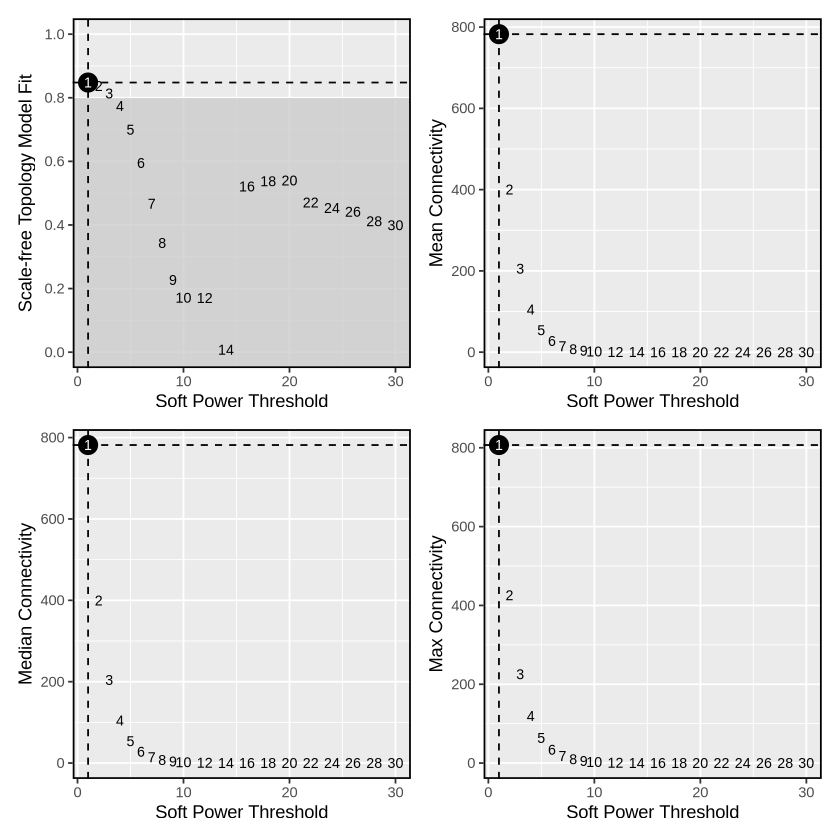

In [33]:
# plot the results:
plot_list <- PlotSoftPowers(data)

power_table <- GetPowerTable(data)

# assemble with patchwork
wrap_plots(plot_list, ncol=2)

In [40]:
data <- ConstructNetwork(
  data, soft_power=10,
  setDatExpr=FALSE,
  tom_name = 'cell_bin', # name of the topoligical overlap matrix written to disk,
  overwrite_tom = TRUE
)

Warning message in ConstructNetwork(data, soft_power = 10, setDatExpr = FALSE, tom_name = "cell_bin", :
“Overwriting TOM TOM/cell_bin_TOM.rda”


 Calculating consensus modules and module eigengenes block-wise from all genes
 Calculating topological overlaps block-wise from all genes
   Flagging genes and samples with too many missing values...
    ..step 1
    TOM calculation: adjacency..
    ..will use 48 parallel threads.
     Fraction of slow calculations: 0.000000
    ..connectivity..
    ..matrix multiplication (system BLAS)..
    ..normalization..
    ..done.
 ..Working on block 1 .
 ..Working on block 1 .
 No modules detected in block 1 --> continuing with next block.
 ..merging consensus modules that are too close..
 blockwiseConsensusModules: mergeCloseModule failed with this message:
       Error in mergeCloseModules(multiExpr, colors[gsg$goodGenes], equalizeQuantiles = equalizeQuantilesForModuleMerging,  : 
  Error in moduleEigengenes(expr = exprData[[set]]$data, colors = setColors,  : 
  Color levels are empty. Possible reason: the only color is grey and grey module is excluded from the calculation.

  ---> returnin

An object of class Seurat 
52124 features across 398741 samples within 1 assay 
Active assay: RNA (52124 features, 2000 variable features)
 3 layers present: counts, data, scale.data
 1 dimensional reduction calculated: pca

In [2]:
data = readRDS("../Result/WGCNA/WGCNA_concentric.RDS")

[1] "Con-M1"
[1] "Con-M2"
[1] "Con-M1"
[1] "Con-M2"


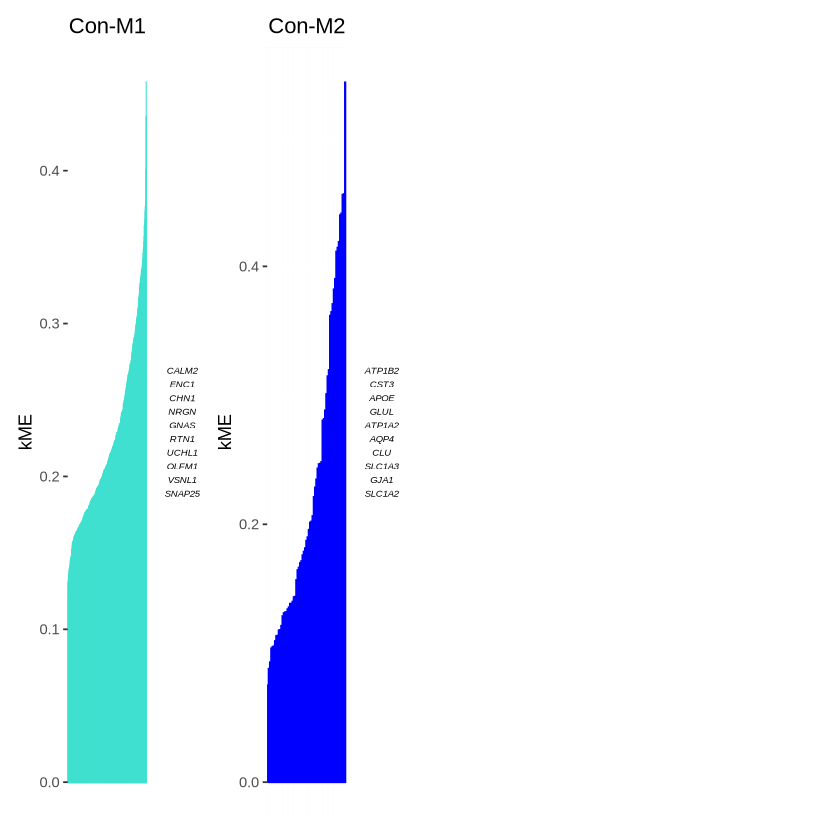

In [35]:
p <- PlotKMEs(data, ncol=5)
p

In [3]:
data

An object of class Seurat 
52124 features across 86626 samples within 1 assay 
Active assay: RNA (52124 features, 2000 variable features)
 3 layers present: counts, data, scale.data
 1 dimensional reduction calculated: pca

In [39]:
ModuleNetworkPlot(data)

Writing output files to ModuleNetworks

ERROR: Error in dimnames(x) <- dn: length of 'dimnames' [1] not equal to array extent


In [38]:
data@misc$vis$wgcna_modules

,gene_name,module,color,kME_grey,kME_Con-M1,kME_Con-M2
,<chr>,<fct>,<chr>,<dbl>,<dbl>,<dbl>
AAK1,AAK1,grey,grey,0.145491501,0.12843978,-0.0074735251
AARS,AARS,grey,grey,0.144334648,0.13326911,0.0131279758
AATK,AATK,grey,grey,0.092680674,0.07243949,-0.0067706106
ABAT,ABAT,grey,grey,0.114763054,0.11022136,0.0196130092
ABCA2,ABCA2,grey,grey,0.049703605,0.02631689,-0.0012604839
ABCA3,ABCA3,grey,grey,0.131737872,0.11934573,0.0356600068
ABHD12,ABHD12,grey,grey,0.133359804,0.13292506,0.0159053018
ABI2,ABI2,grey,grey,0.160434592,0.14796046,0.0067506919
ABLIM1,ABLIM1,grey,grey,0.035671029,0.02142591,0.0467029781


In [8]:
data <- ModuleConnectivity(
  data,
  group.by = 'annotation', group_name = 'INH'
)

In [4]:
ModuleNetworkPlot(data)

Writing output files to ModuleNetworks

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by ‘BiocGenerics’

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by ‘BiocGenerics’



ERROR: Error in dimnames(x) <- dn: length of 'dimnames' [1] not equal to array extent


In [ ]:
# Test different soft powers:
data <- TestSoftPowers(
  data,
  networkType = 'signed' # you can also use "unsigned" or "signed hybrid"
)

# plot the results:
plot_list <- PlotSoftPowers(data)

# assemble with patchwork
wrap_plots(plot_list, ncol=2)

pickSoftThreshold: will use block size 1369.
 pickSoftThreshold: calculating connectivity for given powers...
   ..working on genes 1 through 1369 of 1369


In [8]:
data <- ConstructNetwork(
  data, soft_power=9,
  setDatExpr=FALSE,
  tom_name = 'INH' # name of the topoligical overlap matrix written to disk
)

 Calculating consensus modules and module eigengenes block-wise from all genes
 Calculating topological overlaps block-wise from all genes
   Flagging genes and samples with too many missing values...
    ..step 1
    TOM calculation: adjacency..
    ..will use 48 parallel threads.
     Fraction of slow calculations: 0.000000
    ..connectivity..
    ..matrix multiplication (system BLAS)..
    ..normalization..
    ..done.
 ..Working on block 1 .
 ..Working on block 1 .
 ..merging consensus modules that are too close..


In [11]:
# need to run ScaleData first or else harmony throws an error:
data <- ScaleData(data, features=VariableFeatures(data))

# compute all MEs in the full single-cell dataset
data <- ModuleEigengenes(
 data,
 group.by.vars="concentric"
)

Centering and scaling data matrix



[1] "grey"


Centering and scaling data matrix

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pcagrey to pcagrey_”
pcagrey_ 1 
Positive:  CLDN5, B2M, S100B, ERBB4, MT-ND4L, RORA, GSTP1, RPS12, RPL23A, MT-ND5 
	   RPS6KA2, RPL21, RPS29, IL1RAPL1, RPS27, MT-ND6, CD63, RPS6, RPS21, RHOB 
	   FP671120.1, RPL27A, RPS16, DNER, BCYRN1, CALR, AC016831.7, RPL30, RPL11, RPS9 
Negative:  MEG3, RBFOX1, HSP90AA1, CAMK2A, KCNIP4, NEGR1, MAPT, PRRT2, RASD1, ANKS1B 
	   MAPK10, SIRPA, DLGAP1, RHBDD2, NRXN1, DMTN, KALRN, NRCAM, MT-CO1, SPTBN1 
	   AES, SNHG14, CNTN1, MIAT, ATP9A, BAIAP2, RANGAP1, SYNGR1, DPYSL2, OPCML 
pcagrey_ 2 
Positive:  RPL21, TPT1, RPL9, RPL36, B2M, RPS27, RPL13A, EIF1, LDHB, RPLP1 
	   RPS27A, RPL35, EEF1A1, RPS10, RPS12, HSP90AA1, RPS6, RPS9, GABARAP, RPS19 
	   RPL11, RPL27A, RPL32, RPL28, RPL27, RPL37, RPS11, MYL6, RPS17, RPS21 
Negative:  MALAT1, KCNIP4, CSMD1, LRRTM4, NRG3, SNHG14, RBFOX1, HFM1, ADGRB3, DPP10 
	   DLG2, 

[1] "turquoise"


Centering and scaling data matrix

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pcaturquoise to pcaturquoise_”
pcaturquoise_ 1 
Positive:  DHFR, GPS2, RPL10, RPL7, RPS23, PHPT1, SCAND1, RPS25, RPL29, DPP7 
	   SELENOM, LAMTOR4, FUS, MRPL41, PFDN5, DGCR2, FIS1, RPS18, RPS20, ATP5MC2 
	   RPL23, ABAT, NDUFB9, RPL26, SERF2, RPL19, RPSA, TRIM44, DSE, ROGDI 
Negative:  SNAP25, VSNL1, OLFM1, UCHL1, RTN1, GNAS, NRGN, CHN1, ENC1, CALM1 
	   CALM2, YWHAG, NEFL, ENO2, MAP1B, ATP1A1, TUBA1B, SYT1, PEBP1, ATP1B1 
	   RTN4, STMN1, THY1, EIF4A2, TMEM59L, RGS4, AC093512.2, STMN2, BEX1, CCK 
pcaturquoise_ 2 
Positive:  SLC17A7, SYT1, NCDN, DNM1, NPTN, CAMK2B, PHYHIP, SYN1, CHN1, SV2B 
	   ATP2B1, PPP3R1, TSPYL1, PTK2B, KIAA1549L, PRKAR1B, ENC1, YWHAG, PPP3CA, PRNP 
	   CHGA, STXBP1, AK5, MKL2, ATRNL1, SNAP25, SCN2A, NPTXR, GRIN1, ATP6V0A1 
Negative:  HSPA8, FTH1, NDUFA4, RPL37A, RPL26, PPIA, MIF, COX6C, RPS18, COX7C 
	   RPS8, ATP5MD,

[1] "brown"


Centering and scaling data matrix

Warning message in irlba(A = t(x = object), nv = npcs, ...):
“You're computing too large a percentage of total singular values, use a standard svd instead.”
Warning message in irlba(A = t(x = object), nv = npcs, ...):
“did not converge--results might be invalid!; try increasing work or maxit”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pcabrown to pcabrown_”
Warning message:
“Requested number is larger than the number of available items (52). Setting to 52.”
Warning message:
“Requested number is larger than the number of available items (52). Setting to 52.”
Warning message:
“Requested number is larger than the number of available items (52). Setting to 52.”
Warning message:
“Requested number is larger than the number of available items (52). Setting to 52.”
Warning message:
“Requested number is larger than the number of available items (52). Setting to 52.”
pcabrown_ 1 
Positive:  P

[1] "blue"


Centering and scaling data matrix

Warning message in irlba(A = t(x = object), nv = npcs, ...):
“You're computing too large a percentage of total singular values, use a standard svd instead.”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pcablue to pcablue_”
pcablue_ 1 
Positive:  SLC1A2, SLC1A3, GJA1, CLU, AQP4, ATP1A2, GLUL, APOE, CST3, ATP1B2 
	   FGFR3, CPE, AGT, PTGDS, GPR37L1, SPARCL1, CD81, AHCYL1, TTYH1, ITM2C 
	   ADGRG1, HTRA1, METTL7A, ALDOC, SERPINE2, NTRK2, SCG3, NDRG2, PCDHGA1, MT1E 
Negative:  MT-RNR1, MT-CO2, MT-RNR2, MT-TL1, WWOX, MT-TV, MT-ATP6, MT-ND3, NEAT1, MT-CYB 
	   MT-ND4, MT-ND2, SORBS1, FMN2, ABLIM1, MT-ND1, LSAMP, CTNND2, NEBL, PRKCA 
	   FAM107A, RDH11, IFITM3, MGLL, MACF1, APC2, HACD3, SRI, NTM, ADCY2 
pcablue_ 2 
Positive:  MT-ATP6, MT-CO2, MT-ND4, MT-RNR2, MT-CYB, MT-ND1, MT-RNR1, MT-ND3, MT-ND2, MT-TV 
	   MT-TL1, GFAP, FTL, FAM107A, MT3, NDRG2, CTSD, ALDOC, CST3, IFITM3 
	   TMBIM6, NAT

In [13]:
# harmonized module eigengenes:
hMEs <- GetMEs(data)

# module eigengenes:
MEs <- GetMEs(data, harmonized=FALSE)


In [20]:
# compute eigengene-based connectivity (kME):
data <- ModuleConnectivity(
  data,
  group.by = 'annotation'
)


In [21]:
# rename the modules
data <- ResetModuleNames(
  data,
  new_name = "Concentric"
)

ERROR: Error in names(x) <- value: 'names' attribute [3] must be the same length as the vector [2]


[1] "turquoise"
[1] "brown"
[1] "blue"
[1] "turquoise"
[1] "brown"
[1] "blue"


Warning message:
“Removed 759 rows containing missing values (`position_stack()`).”
Warning message:
“Removed 52 rows containing missing values (`position_stack()`).”
Warning message:
“Removed 91 rows containing missing values (`position_stack()`).”


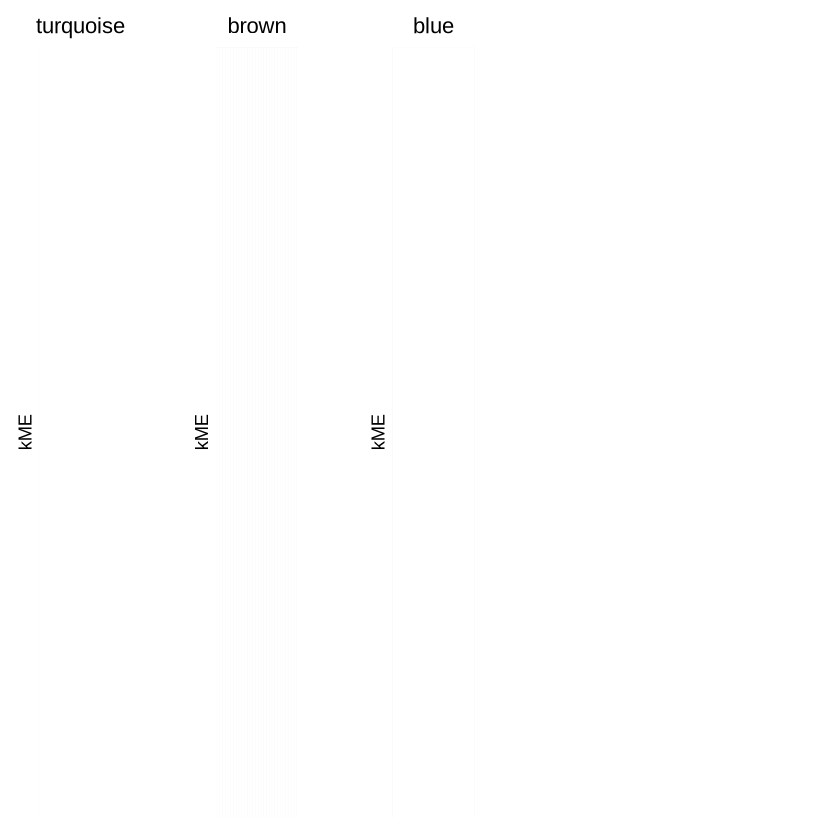

In [22]:
p <- PlotKMEs(data, ncol=5)

p

In [24]:
# get hub genes
hub_df <- GetHubGenes(data, n_hubs = 10)

head(hub_df)

ERROR: Error in `.rowNamesDF<-`(x, value = value): invalid 'row.names' length


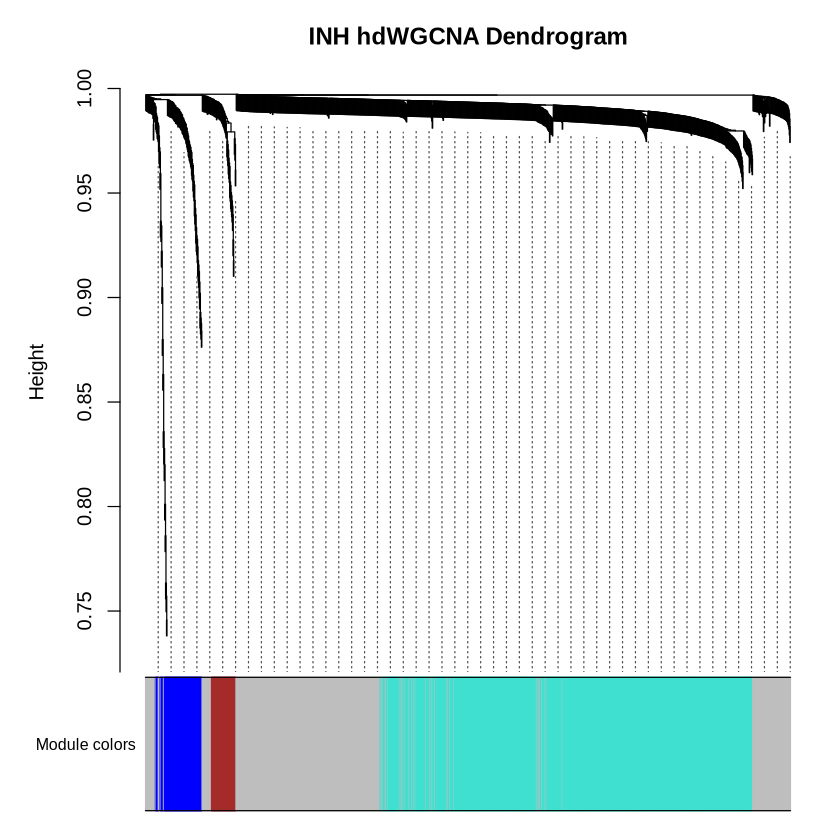

In [12]:
PlotDendrogram(data, main='INH hdWGCNA Dendrogram')

In [9]:
TOM <- GetTOM(data)

In [ ]:
hMEs <- GetMEs(se)


In [10]:
ModuleNetworkPlot(data)

ERROR: Error in ModuleNetworkPlot(data): Eigengene-based connectivity (kME) not found. Did you run ModuleEigengenes and ModuleConnectivity?


In [7]:
control = subset(data, subset = levels == "control")

[1] "Con-M1"
[1] "Con-M2"
[1] "Con-M1"
[1] "Con-M2"


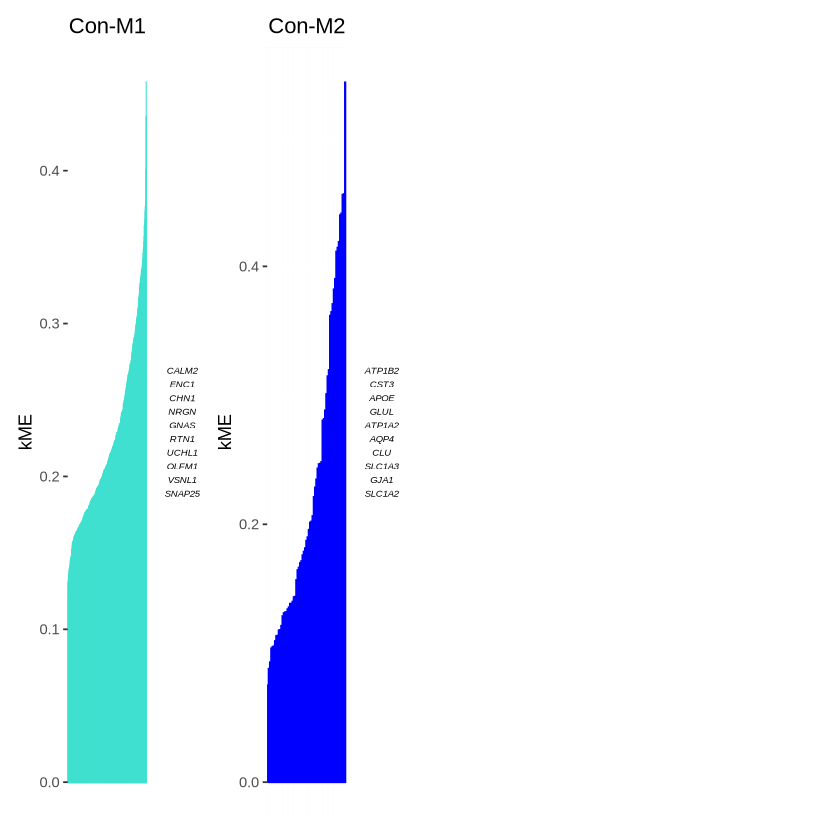

In [8]:
PlotKMEs(control, ncol=5)

In [9]:
control$concentric = factor(control$concentric, levels = c('outer2', 'outer', 'inner'))

control <- ModuleTraitCorrelation(
  control,
  traits = c("concentric"),
  group.by='annotation'
)

Warning message in ModuleTraitCorrelation(control, traits = c("concentric"), group.by = "annotation"):
“Trait concentric is a factor with levels outer2, outer, inner. Levels will be converted to numeric IN THIS ORDER for the correlation, is this the expected order?”


ERROR: Error in cbind(x, y): number of rows of matrices must match (see arg 2)


In [2]:
data = readRDS("../Result/WGCNA/WGCNA_inner_outer3_concentric.RDS")

In [8]:
################### pseudobulk analysis ###############################
#data$annotation = as.factor(data$annotation)
#data$sample = as.factor(data$sample)

datExpr <- ConstructPseudobulk(
  seurat_obj = data,
  group.by = 'annotation',
  replicate_col = 'sample',
  label_col = "levels",
  assay = 'RNA',
  slot = 'counts', # this should always be counts!
  min_reps = 10
)

Warning message in ConstructPseudobulk(seurat_obj = data, group.by = "annotation", :
“We strongly recommend at least 20 replicates for pseudobulk hdWGCNA, and there are only 11 replicates detected. Results may not be reproducible or informative with low numbers of replicates so proceed at your own risk.”


[1] "Ast"
[1] "End"
[1] "Ex"
[1] "Inh"
[1] "Mic"
[1] "Oli"
[1] "Opc"


In [9]:
# compute log2CPM normalization
# You can substitute this with another normalization of your choosing.
cpm <- t(apply(datExpr, 1, function(x){
    y <- (x) / sum(x) * 1000000
    log2(y + 1)
}))

data <- SetDatExpr(
  data,
  mat = cpm
)

Warning message in SetDatExpr(data, mat = cpm):
“assay not specified, trying to use assay RNA”


In [54]:
unique(data@meta.data$annotation)

[1] "Ex"  "Ast" "End" "Oli" "Opc" "Inh" "Mic"

In [55]:
# we only want the data from the astrocytes 
cur_group <- unique(data@meta.data$annotation)

# subset the matrix for just this cell type
cur_cpm <- cpm[grepl(cur_group, rownames(cpm)),]

data <- SetDatExpr(
  data,
  mat = cur_cpm
)

Warning message in grepl(cur_group, rownames(cpm)):
“argument 'pattern' has length > 1 and only the first element will be used”
Warning message in SetDatExpr(data, mat = cur_cpm):
“assay not specified, trying to use assay RNA”


In [56]:
# select the soft power threshold
data <- TestSoftPowers(
    data,
    networkType = 'signed'
)

pickSoftThreshold: will use block size 1532.
 pickSoftThreshold: calculating connectivity for given powers...
   ..working on genes 1 through 1532 of 1532
   Power SFT.R.sq slope truncated.R.sq mean.k. median.k. max.k.
1      1  0.00757  1.23          0.526  769.00    773.00  820.0
2      2  0.06480 -2.21          0.775  443.00    435.00  530.0
3      3  0.22600 -2.50          0.857  279.00    273.00  382.0
4      4  0.26300 -1.86          0.919  187.00    182.00  290.0
5      5  0.30000 -1.53          0.931  132.00    126.00  228.0
6      6  0.35700 -1.43          0.915   96.50     90.70  184.0
7      7  0.41600 -1.33          0.910   72.70     66.80  151.0
8      8  0.49300 -1.35          0.910   56.10     50.40  127.0
9      9  0.53600 -1.32          0.906   44.20     38.90  107.0
10    10  0.60700 -1.25          0.923   35.40     30.30   91.7
11    12  0.71300 -1.20          0.936   23.70     19.30   68.6
12    14  0.79100 -1.31          0.954   16.60     12.80   54.4
13    16  0.7

  Power    SFT.R.sq     slope truncated.R.sq   mean.k. median.k.   max.k.
1     1 0.007570573  1.230871      0.5260738 769.33487 772.82716 819.8665
2     2 0.064843620 -2.205110      0.7749643 442.85767 435.36692 529.6884
3     3 0.226490534 -2.498861      0.8567482 278.96469 273.40986 381.7483
4     4 0.263471365 -1.859195      0.9194431 187.34870 182.08046 290.1904
5     5 0.299594825 -1.534890      0.9314021 131.99414 126.37848 228.3540
6     6 0.356846619 -1.429660      0.9146174  96.51938  90.66998 184.1611


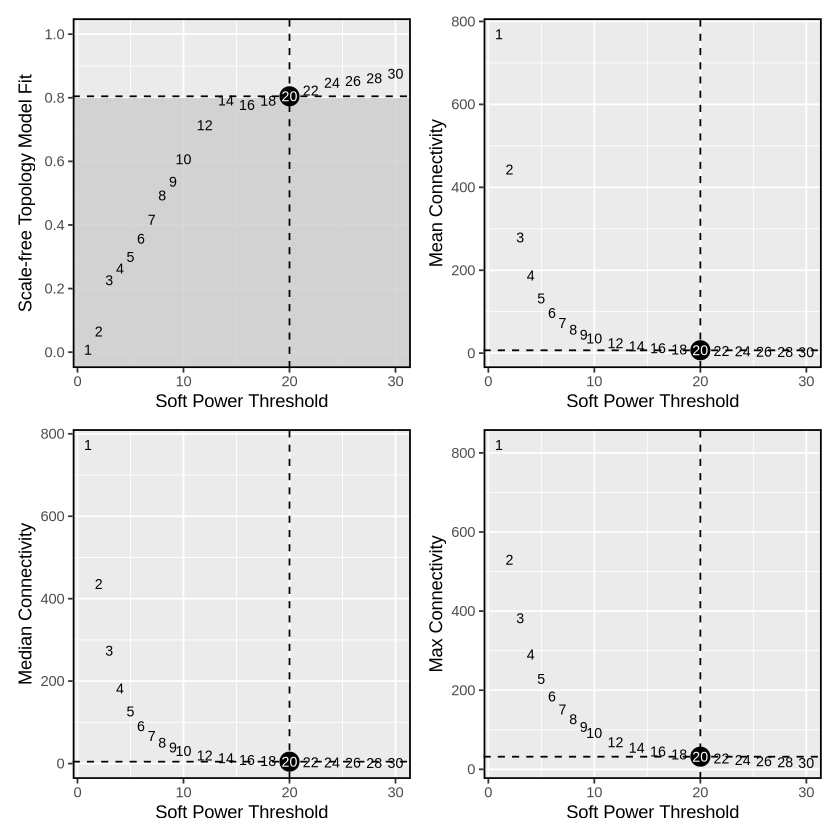

In [57]:
# plot the results:
plot_list <- PlotSoftPowers(data)

# assemble with patchwork
wrap_plots(plot_list, ncol=2)

Warning message in ConstructNetwork(data, tom_name = "pseudobulk", overwrite_tom = TRUE, :
“Overwriting TOM TOM/pseudobulk_TOM.rda”


 Calculating consensus modules and module eigengenes block-wise from all genes
 Calculating topological overlaps block-wise from all genes
   Flagging genes and samples with too many missing values...
    ..step 1
    TOM calculation: adjacency..
    ..will use 48 parallel threads.
     Fraction of slow calculations: 0.000000
    ..connectivity..
    ..matrix multiplication (system BLAS)..
    ..normalization..
    ..done.
 ..Working on block 1 .
 ..Working on block 1 .
 ..merging consensus modules that are too close..


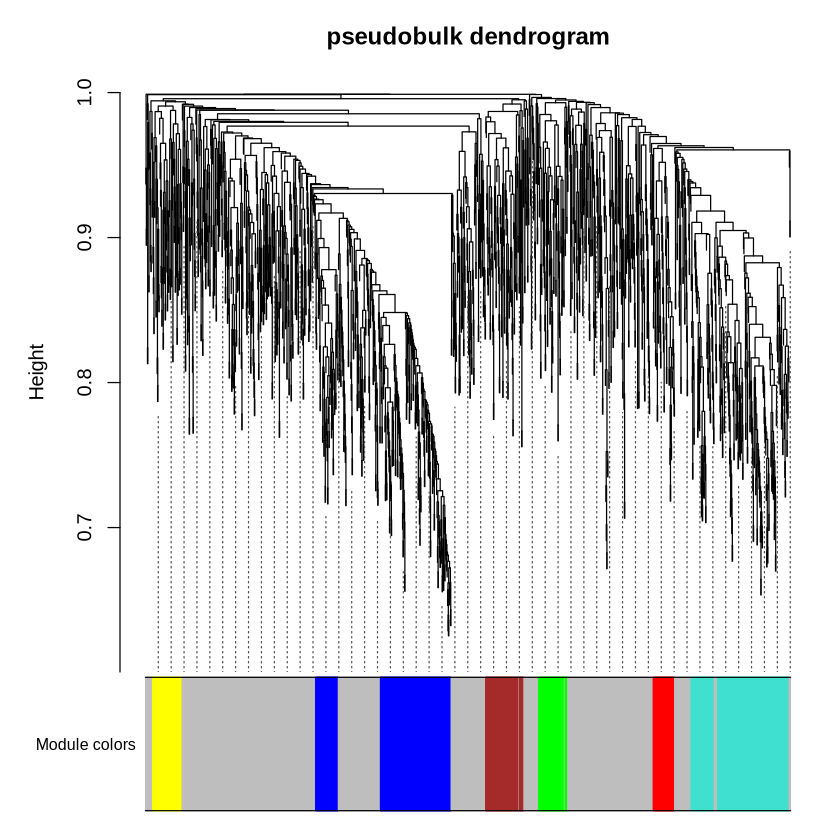

In [58]:
# construct the co-expression network and identify gene modules
data <- ConstructNetwork(
    data, 
    tom_name='pseudobulk', 
    overwrite_tom=TRUE,
    soft_power=20
)

PlotDendrogram(data, main='pseudobulk dendrogram')

[1] "grey"


Centering and scaling data matrix

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pcagrey to pcagrey_”
pcagrey_ 1 
Positive:  MT-RNR2, NEAT1, GFAP, QKI, TF, CLDN11, SLC1A3, ATP1A2, GJA1, NPAS3 
	   SOX2-OT, SCD, SLC44A1, GLUL, PIP4K2A, CSRP1, CLDND1, HTRA1, WWOX, IFITM3 
	   GSN, MT-TV, MT1E, MARCKSL1, MT-TL1, NDRG2, FMNL2, QDPR, MT-RNR1, PLEKHB1 
Negative:  SNAP25, RTN1, SYT1, YWHAG, MAP1B, CALM1, GNAS, NEFL, ATP1B1, TMEM59L 
	   THY1, ATP1A1, EIF4A2, RTN3, PHYHIP, STXBP1, STMN2, GAPDH, PRNP, RTN4 
	   IDS, AC093512.2, YWHAH, SLC17A7, RAB6B, PRKAR1B, NEFM, TMEM130, SERINC1, NSF 
pcagrey_ 2 
Positive:  MEG3, ATRNL1, PDE4D, HS6ST3, KCNQ5, OPCML, SYT1, RIMS2, SNAP25, RYR2 
	   RALYL, R3HDM1, ROBO2, PHACTR1, RGS7, GRIN2B, CELF2, SLC8A1, DPP6, ATP2B1 
	   PPP3CA, PRKCB, NAV3, FGF12, MYT1L, GRIN2A, ARPP21, TMEM59L, GRIA4, PHYHIP 
Negative:  TF, CLDND1, QDPR, SCD, CLDN11, QKI, GPM6B, SOX2-OT, EDIL3, CSRP1 
	   TUBA1A, GLUL, PI

[1] "brown"


Centering and scaling data matrix

Warning message in irlba(A = t(x = object), nv = npcs, ...):
“You're computing too large a percentage of total singular values, use a standard svd instead.”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pcabrown to pcabrown_”
pcabrown_ 1 
Positive:  CHN1, KIF5C, DYNC1H1, TOMM20, CTSB, CLTC, HK1, AMPH, NEUROD2, KIFAP3 
	   APBB1, IQSEC1, CAMK2D, RETREG2, GNAO1, PRPF19, MAPK8IP2, ATP6AP2, ATCAY, SEPT7 
	   P4HTM, SLC8A2, SUGP2, FAM49A, PRKAR2B, MFSD6, EIF4G2, GOLM1, NDUFS2, C9orf16 
Negative:  PLP1, SELENOP, SPP1, METTL7A, CNP, NDRG1, CNTN2, MAP4K4, ABCA2, DTNA 
	   SECISBP2L, DNM3, SPAG9, ANKRD12, SCD5, PRUNE2, GPS2, HP1BP3, HACD3, OMG 
	   ACADVL, NCOR2, ARGLU1, CTSF, RACK1, CASKIN1, ALKBH5, GRIA1, CDC42SE2, BCLAF1 
pcabrown_ 2 
Positive:  PLP1, CNP, SELENOP, SPP1, ABCA2, NDRG1, CNTN2, SCD5, SECISBP2L, SEPT7 
	   MAP4K4, PRUNE2, OMG, ITPK1, SPAG9, DNM3, GNAO1, MFSD6, CLCN4, RACK1 
	   

[1] "turquoise"


Centering and scaling data matrix

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pcaturquoise to pcaturquoise_”
pcaturquoise_ 1 
Positive:  AQP4, AGT, ADGRG1, ATP1B2, TSC22D4, APOE, MBP, TUBB2B, MAG, HLA-A 
	   MT2A, PTGDS, S100B, B2M, TPP1, AHCYL1, CRYAB, ASPH, ALDH2, PFN1 
	   PTP4A2, SEPT4, CST3, SYS1-DBNDD2, RHOA, HSPB1, H3F3B, RPL23A, CD63, SGTA 
Negative:  VSNL1, CALM2, PEBP1, TMSB10, STMN1, MDH1, RGS4, HSP90AA1, HSP90AB1, UBB 
	   TMSB4X, SOD1, UQCRH, SNRPN, MIF, SELENOW, FTH1, OAZ1, ATP5MD, TSC22D1 
	   COX4I1, COX5B, AC091167.2, HINT1, COX7C, ACTG1, PGK1, RPL37A, RPL15, EIF1 
pcaturquoise_ 2 
Positive:  PTGDS, CRYAB, AQP4, MBP, CST3, APOE, AGT, ATP1B2, SYS1-DBNDD2, CD81 
	   MT2A, MAG, TSC22D4, FTL, S100B, FTH1, B2M, ADGRG1, AHCYL1, HLA-A 
	   SEPT4, TUBB2B, H3F3B, TPP1, RPS12, RPS6, RPS27, RPL37A, ITM2C, CD63 
Negative:  VSNL1, RGS4, HSP90AB1, SNRPN, MDH1, SCG5, KCNJ3, MAPK9, RAB3C, GNG3 
	   TMSB10, RNF11, HS

[1] "blue"


Centering and scaling data matrix

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pcablue to pcablue_”
pcablue_ 1 
Positive:  GPRC5B, LAMP2, APOD, ERBB4, IL1RAPL1, ZEB2, RORA, SIK3, NCAN, CADM1 
	   MACF1, NCAM2, CCDC88A, PLEC, AUTS2, NEBL, PCDH9, FMN2, MAPK8IP1, JMJD1C 
	   NUMA1, MT-ND6, LRRC4C, NCOA1, NTM, CLIP2, DMD, NFIX, LRP1B, PDZD2 
Negative:  NRGN, DNM1, ENO2, NCDN, NPTN, GRIN1, APP, RBFOX1, NDRG4, SYN1 
	   DKK3, TSPYL1, TSPAN7, SV2B, SULT4A1, NELL2, PLD3, GPI, KCNIP4, GRIA2 
	   RAB3A, NEGR1, CAMK2A, MAPK10, DMTN, SCN2A, NRXN1, GRIA3, NAP1L2, MAPK1 
pcablue_ 2 
Positive:  MALAT1, KCNIP4, NRG3, CSMD1, LRRTM4, SNHG14, ADGRB3, FTX, MAGI2, DPP10 
	   PCDH9, DLG2, LRP1B, CNTNAP2, KAZN, RBFOX1, FGF14, ASIC2, IL1RAPL1, PTPRD 
	   FRMD4A, FAM155A, NRXN3, DLGAP2, LSAMP, NKAIN2, DSCAM, AUTS2, TENM2, DMD 
Negative:  NRGN, ENO2, APP, RAB3A, TSPAN7, PLD3, NCDN, DKK3, SULT4A1, NDRG4 
	   DNM1, TUBA4A, NPTN, PINK1, TSPYL1, S

[1] "yellow"


Centering and scaling data matrix

Warning message in irlba(A = t(x = object), nv = npcs, ...):
“You're computing too large a percentage of total singular values, use a standard svd instead.”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pcayellow to pcayellow_”
pcayellow_ 1 
Positive:  ENC1, CLSTN1, GDI1, CALM3, CABP1, PREPL, VAMP2, PJA2, USP22, ARF3 
	   TOLLIP, CDK5R1, PRRT2, ABR, GAS7, SLCO5A1, ATL1, SYNPO, PIP4K2B, SLC6A17 
	   DOC2A, ADCY1, CRYM, MADD, FAM213A, LY6E, ENSA, PTPRN2, PRRT1, ALDOC 
Negative:  CLDN5, GPR37L1, FGFR3, GDF1, METRN, FAM107A, SLC1A2, GPHN, RAMP1, TMBIM6 
	   FOXP1, TCF4, ACAP3, CRTC1, XRCC6, MAZ, ATN1, PPFIA2, NDUFS3, CDKL5 
	   PDXK, TTBK2, APC2, RABGAP1, TCEA2, CRIP2, SUMO3, NARS, NTRK2, GRB2 
pcayellow_ 2 
Positive:  CABP1, ENC1, CALM3, GAS7, CRYM, BTBD8, PTPRN2, ATL1, CDK5R1, LY6E 
	   PREPL, PJA2, ADAM11, ADCY1, DOC2A, PPP2R2C, PRRT1, PRRT2, CDKL5, PIP4K2B 
	   PPFIA2, SUMO3, TOLLIP, A

[1] "red"


Centering and scaling data matrix

Warning message in irlba(A = t(x = object), nv = npcs, ...):
“You're computing too large a percentage of total singular values, use a standard svd instead.”
Warning message in irlba(A = t(x = object), nv = npcs, ...):
“did not converge--results might be invalid!; try increasing work or maxit”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pcared to pcared_”
Warning message:
“Requested number is larger than the number of available items (51). Setting to 51.”
Warning message:
“Requested number is larger than the number of available items (51). Setting to 51.”
Warning message:
“Requested number is larger than the number of available items (51). Setting to 51.”
Warning message:
“Requested number is larger than the number of available items (51). Setting to 51.”
Warning message:
“Requested number is larger than the number of available items (51). Setting to 51.”
pcared_ 1 
Positive:  UCHL1, 

[1] "green"


Centering and scaling data matrix

Warning message in irlba(A = t(x = object), nv = npcs, ...):
“You're computing too large a percentage of total singular values, use a standard svd instead.”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pcagreen to pcagreen_”
pcagreen_ 1 
Positive:  OLFM1, TUBA1B, TUBB2A, BASP1, NDUFA4, YWHAB, DYNLL1, SPARCL1, PCSK1N, MLLT11 
	   ATP6V1E1, HSPA8, PRKACB, SLC25A4, ATP6V0E2, ATP2A2, SNCA, SYT11, LDHB, GOT1 
	   DYNLL2, RCAN2, MAP2K1, CHGB, TERF2IP, NDUFB1, NAP1L3, UQCR10, PNMA1, ATP5MG 
Negative:  HFM1, SLC6A1, LUC7L, TUFM, FASN, RAD21, LRP1, DPP7, MARCKS, SCAND1 
	   GPX1, TIMP2, PCDHA1, HECTD4, YWHAQ, IPO5, PAIP2, NDUFB10, SSU72, MZT2A 
	   ATXN10, EIF3K, LRPAP1, LGALS1, SLIRP, CAMLG, RBX1, NAA38, NDUFB7, ITPR1 
pcagreen_ 2 
Positive:  HFM1, HPCAL4, SNCA, ATP2A2, DYNLL2, PRKACB, WDR82, ITPR1, TUBA1B, LUC7L 
	   BASP1, FASN, PCDHA1, NAP1L3, TERF2IP, HECTD4, SSU72, IPO5, ATP6V1E1, DPP7 


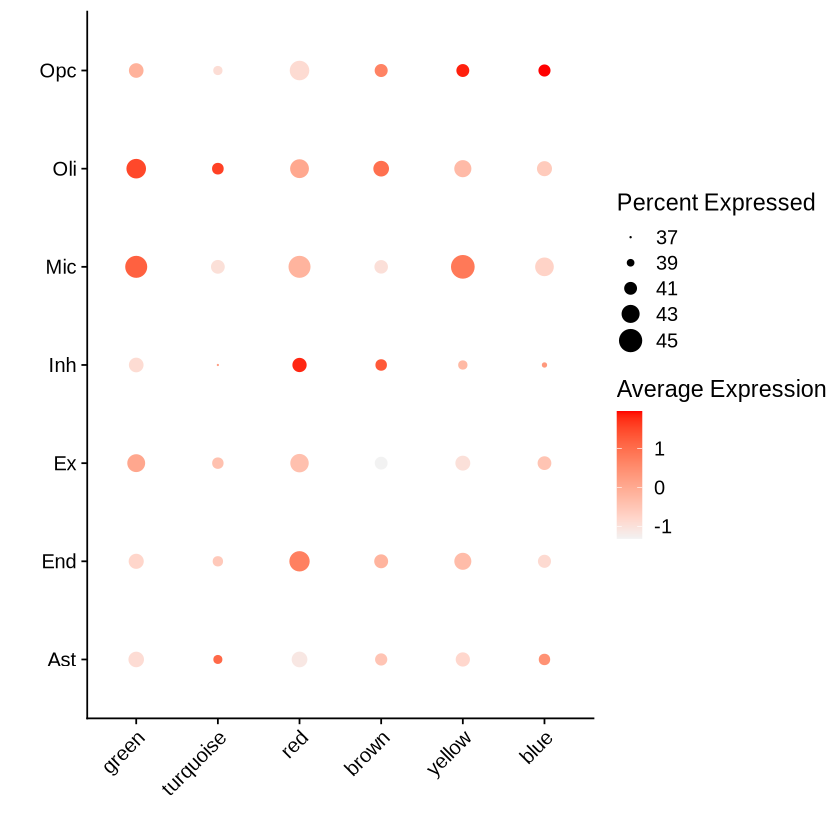

In [59]:
data <- ModuleEigengenes(data)
data <- ModuleConnectivity(data)

# get MEs from seurat object
MEs <- GetMEs(data)
mods <- colnames(MEs); mods <- mods[mods != 'grey']

# add MEs to Seurat meta-data for plotting:
data@meta.data <- cbind(data@meta.data, MEs)

# plot with Seurat's DotPlot function
p <- DotPlot(data, features=mods, group.by = 'annotation')

# flip the x/y axes, rotate the axis labels, and change color scheme:
p <- p +
  RotatedAxis() +
  scale_color_gradient(high='red', low='grey95') + 
  xlab('') + ylab('')


p 

[1] "brown"
[1] "turquoise"
[1] "blue"
[1] "yellow"
[1] "red"
[1] "green"
[1] "brown"
[1] "turquoise"
[1] "blue"
[1] "yellow"
[1] "red"
[1] "green"


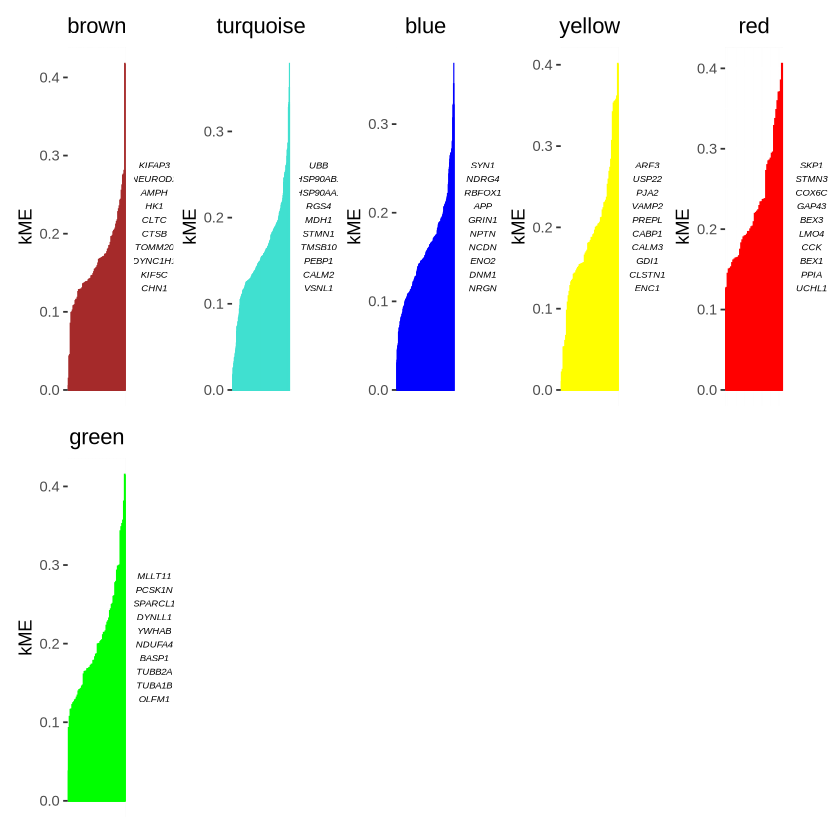

In [60]:
p <- PlotKMEs(data, ncol=5)

p

In [61]:
hub_df <- GetHubGenes(data, n_hubs = 10)

In [62]:
data$levels = factor(data$levels, levels = c("control", "moderate", "advanced", "severe"))
data$concentric = as.factor(data$concentric)
data$diagnosis = as.factor(data$diagnosis)

In [63]:
cur_traits = c("levels", "concentric","diagnosis")
data <- ModuleTraitCorrelation(
  data,
  traits = cur_traits,
  group.by='annotation'
)

Warning message in ModuleTraitCorrelation(data, traits = cur_traits, group.by = "annotation"):
“Trait levels is a factor with levels control, moderate, advanced, severe. Levels will be converted to numeric IN THIS ORDER for the correlation, is this the expected order?”
Warning message in ModuleTraitCorrelation(data, traits = cur_traits, group.by = "annotation"):
“Trait concentric is a factor with levels inner, outer, outer2. Levels will be converted to numeric IN THIS ORDER for the correlation, is this the expected order?”
Warning message in ModuleTraitCorrelation(data, traits = cur_traits, group.by = "annotation"):
“Trait diagnosis is a factor with levels case, control. Levels will be converted to numeric IN THIS ORDER for the correlation, is this the expected order?”


In [64]:
mt_cor <- GetModuleTraitCorrelation(data)

names(mt_cor)

[1] "cor"  "pval" "fdr"

In [65]:
mt_cor

,brown,turquoise,blue,yellow,red,green
levels,0.0009293351,0.08303327,-0.02369957,0.02394511,0.07301800,0.05086054
concentric,-0.0170779912,-0.04861890,-0.01739753,-0.05084930,-0.03413227,-0.02049143
diagnosis,-0.0077045835,-0.04895947,0.01468034,-0.01474084,-0.04490494,-0.03706309
,brown,turquoise,blue,yellow,red,green
levels,0.001882205,0.06119603,-0.017237341,0.02127416,0.05228320,0.027195890
concentric,-0.017198833,-0.03860887,-0.019919848,-0.05543335,-0.02071143,-0.007131172
diagnosis,-0.011895017,-0.05049487,0.005315157,-0.01875843,-0.04509124,-0.027343237
,brown,turquoise,blue,yellow,red,green
levels,-0.01396015,0.08160441,-0.03341636,0.018218946,0.06253165,0.04334166
concentric,-0.01224467,-0.05085879,-0.01960417,-0.059477765,-0.03674742,-0.01375726


In [13]:
data@meta.data$annotation = as.factor(data@meta.data$annotation)
data@meta.data$sample = as.factor(data@meta.data$sample)

In [18]:
class(data@meta.data[,"sample"]) %in% c('character', 'factor')

[1] TRUE

In [22]:
class(data@meta.data[,"sample"])

[1] "factor"

In [18]:
data@meta.data$annotation = as.factor(data@meta.data$annotation)
data@meta.data$sample = as.factor(data@meta.data$sample)

In [28]:
seurat_obj = data
group.by = 'annotation'
replicate_col = 'sample'
assay = 'RNA'
slot = 'counts' # this should always be counts!
min_reps = 10
# get data from active assay if wgcna_name is not given
if(is.null(wgcna_name)){wgcna_name <- seurat_obj@misc$active_wgcna}
    if(!CheckWGCNAName(seurat_obj, wgcna_name)){
        stop(paste0("Invalid wgcna_name supplied: ", wgcna_name))
}  

# check that selected assay is in the seurat object 
if(!(assay %in% Assays(seurat_obj))){
stop(paste0('Invalid choice of assay: ', assay, ' not found in Assays(seurat_obj).'))
}

# check that slot is valid 
if(!(slot %in% c('counts', 'data', 'scale.data'))){
stop('Invalid choice of slot. Valid choices are counts, data, or scale.data.')
}

# check that group.by is valid 
if(!(group.by %in% names(seurat_obj@meta.data))){
stop(paste0(group.by, ' not found in seurat_obj@meta.data.'))
}
if(!(class(seurat_obj@meta.data[,group.by]) %in% c('character', 'factor'))){
stop('Selected group.by must be a character or a factor, but ', group.by, ' is a ', class(seurat_obj@meta.data[,group.by]), '.')
}

# check that replicate_col is valid
if(!(class(seurat_obj@meta.data[,replicate_col]) %in% c('character', 'factor'))){
stop('Selected replicate_col must be a character or a factor, but ', replicate_col, ' is a ', class(seurat_obj@meta.data[,replicate_col]), '.')
}

# check that label_col is valid
if(!(class(seurat_obj@meta.data[,label_col]) %in% c('character', 'factor'))){
stop('Selected label_col must be a character or a factor, but ', label_col, ' is a ', class(seurat_obj@meta.data[,label_col]), '.')
}

# check that the current assay is the selected assay:
if(DefaultAssay(seurat_obj) != assay){
stop('DefaultAssay(seurat_obj) is not ', assay, ' please switch the default assay to the desired assay before running this function.')
}

# check how many replicates we have:
n_reps <- length(unique(seurat_obj@meta.data[[replicate_col]]))
if(n_reps < min_reps){
    stop(paste0('The number of biological replicates (', n_reps, ') is smaller than min_reps (', min_reps, ')'))
} 
if(n_reps < 20){
    warning(paste0("We strongly recommend at least 20 replicates for pseudobulk hdWGCNA, and there are only ", n_reps, " replicates detected. Results may not be reproducible or informative with low numbers of replicates so proceed at your own risk."))
}

# get the WGCNA genes:
genes_use <- GetWGCNAGenes(seurat_obj, wgcna_name)

# get counts matrix
X <- Seurat::GetAssayData(seurat_obj, assay=assay, slot=slot)

# get pseudobulk replicates
pseudobulk_list <- to_pseudobulk(
    X, meta = seurat_obj@meta.data,
    cell_type_col = group.by,
    replicate_col = replicate_col,
    label_col = label_col,
    min_reps=0
)

# merge lists into a matrix
datExpr <- Reduce(cbind, lapply(names(pseudobulk_list), function(x){
    cur <- pseudobulk_list[[x]]
    colnames(cur) <- paste0(x, ':', colnames(cur))
    cur
}))
datExpr <- t(datExpr[genes_use,])


ERROR: Error in eval(expr, envir, enclos): object 'wgcna_name' not found


In [36]:
to_pseudobulk = function(input, 
                         meta = NULL, 
                         replicate_col = 'replicate',
                         cell_type_col = 'cell_type',
                         label_col = 'label',
                         min_cells = 3,
                         min_reps = 2,
                         min_features = 0,
                         external = T) {
  if (external) {
    # first, make sure inputs are correct
    inputs = check_inputs(
      input, 
      meta = meta,
      replicate_col = replicate_col,
      cell_type_col = cell_type_col,
      label_col = label_col)
    expr = inputs$expr
    meta = inputs$meta
  } else {
    expr = input
  }

  # convert to characters
  meta %<>% mutate(replicate = as.character(replicate),
                   cell_type = as.character(cell_type),
                   label = as.character(label))
  
  # keep only cell types with enough cells
  keep = meta %>%
    dplyr::count(cell_type, label) %>%
    group_by(cell_type) %>%
    filter(all(n >= min_cells)) %>%
    pull(cell_type) %>%
    unique()
  
  # process data into gene x replicate x cell_type matrices
  pseudobulks = keep %>%
    map( ~ {
      print(.)
      cell_type = .
      meta0 = meta %>% filter(cell_type == !!cell_type)
      expr0 = expr %>% magrittr::extract(, meta0$cell_barcode)
      # catch cell types without replicates or conditions
      if (n_distinct(meta0$label) < 2)
        return(NA)
      replicate_counts = distinct(meta0, label, replicate) %>%
        group_by(label) %>%
        summarise(replicates = n_distinct(replicate)) %>%
        pull(replicates)
      if (any(replicate_counts < min_reps))
        return(NA)
      
      # process data into gene X replicate X cell_type matrice
      mm = model.matrix(~ 0 + replicate:label, data = meta0)
      mat_mm = expr0 %*% mm
      keep_genes = rowSums(mat_mm > 0) >= min_features
      mat_mm = mat_mm[keep_genes, ] %>% as.data.frame()
      mat_mm %<>% as.data.frame()
      colnames(mat_mm) = gsub("replicate|label", "", colnames(mat_mm))
      # drop empty columns
      keep_samples = colSums(mat_mm) > 0
      mat_mm %<>% magrittr::extract(, keep_samples)
      return(mat_mm)
    }) %>%
    setNames(keep)
  
  # drop NAs
  pseudobulks %<>% magrittr::extract(!is.na(.))
  
  # also filter out cell types with no retained genes
  min_dim = map(pseudobulks, as.data.frame) %>% map(nrow)
  pseudobulks %<>% magrittr::extract(min_dim > 1)
  
  # also filter out types without replicates
  min_repl = map_int(pseudobulks, ~ {
    # make sure we have a data frame a not a vector
    tmp = as.data.frame(.)
    targets = data.frame(group_sample = colnames(tmp)) %>%
      mutate(group = gsub(".*\\:", "", group_sample))
    if (n_distinct(targets$group) == 1)
      return(as.integer(0))
    min(table(targets$group))
  })
  pseudobulks %<>% magrittr::extract(min_repl >= min_reps)
  return(pseudobulks)
}


In [29]:
ConstructPseudobulk <- function(
  seurat_obj,
  group.by,
  replicate_col,
  label_col = NULL,
  assay = 'RNA',
  slot = 'counts',
  min_reps = 20,
  wgcna_name = NULL
){

    # get data from active assay if wgcna_name is not given
    if(is.null(wgcna_name)){wgcna_name <- seurat_obj@misc$active_wgcna}
        if(!CheckWGCNAName(seurat_obj, wgcna_name)){
            stop(paste0("Invalid wgcna_name supplied: ", wgcna_name))
    }  

  # check that selected assay is in the seurat object 
  if(!(assay %in% Assays(seurat_obj))){
    stop(paste0('Invalid choice of assay: ', assay, ' not found in Assays(seurat_obj).'))
  }

  # check that slot is valid 
  if(!(slot %in% c('counts', 'data', 'scale.data'))){
    stop('Invalid choice of slot. Valid choices are counts, data, or scale.data.')
  }

  # check that group.by is valid 
  if(!(group.by %in% names(seurat_obj@meta.data))){
    stop(paste0(group.by, ' not found in seurat_obj@meta.data.'))
  }
  if(!(class(seurat_obj@meta.data[,group.by]) %in% c('character', 'factor'))){
    stop('Selected group.by must be a character or a factor, but ', group.by, ' is a ', class(seurat_obj@meta.data[,group.by]), '.')
  }

  # check that replicate_col is valid
  if(!(class(seurat_obj@meta.data[,replicate_col]) %in% c('character', 'factor'))){
    stop('Selected replicate_col must be a character or a factor, but ', replicate_col, ' is a ', class(seurat_obj@meta.data[,replicate_col]), '.')
  }

  # check that label_col is valid
  print(class(data@meta.data[,"sample"]) %in% c('character', 'factor'))
  print(class(data@meta.data[,"annotation"]) %in% c('character', 'factor'))
    
  if(!(class(seurat_obj@meta.data[,label_col]) %in% c('character', 'factor'))){
    stop('Selected label_col must be a character or a factor, but ', label_col, ' is a ', class(seurat_obj@meta.data[,label_col]), '.')
  }

  # check that the current assay is the selected assay:
  if(DefaultAssay(seurat_obj) != assay){
    stop('DefaultAssay(seurat_obj) is not ', assay, ' please switch the default assay to the desired assay before running this function.')
  }

    # check how many replicates we have:
    n_reps <- length(unique(seurat_obj@meta.data[[replicate_col]]))
    if(n_reps < min_reps){
        stop(paste0('The number of biological replicates (', n_reps, ') is smaller than min_reps (', min_reps, ')'))
    } 
    if(n_reps < 20){
        warning(paste0("We strongly recommend at least 20 replicates for pseudobulk hdWGCNA, and there are only ", n_reps, " replicates detected. Results may not be reproducible or informative with low numbers of replicates so proceed at your own risk."))
    }

    # get the WGCNA genes:
    genes_use <- GetWGCNAGenes(seurat_obj, wgcna_name)

    # get counts matrix
    X <- Seurat::GetAssayData(seurat_obj, assay=assay, slot=slot)

    # get pseudobulk replicates
    pseudobulk_list <- to_pseudobulk(
        X, meta = seurat_obj@meta.data,
        cell_type_col = group.by,
        replicate_col = replicate_col,
        label_col = label_col,
        min_reps=0
    )

    # merge lists into a matrix
    datExpr <- Reduce(cbind, lapply(names(pseudobulk_list), function(x){
        cur <- pseudobulk_list[[x]]
        colnames(cur) <- paste0(x, ':', colnames(cur))
        cur
    }))
    datExpr <- t(datExpr[genes_use,])

    # return the pseudobulk matrix:
    datExpr

}


In [38]:
check_inputs = function(input,
                        meta = meta,
                        replicate_col = 'replicate',
                        cell_type_col = 'cell_type',
                        label_col = 'label') {

  # extract cell types and label from metadata
  if ("Seurat" %in% class(input)) {
    # confirm Seurat is installed
    if (!requireNamespace("Seurat", quietly = TRUE)) {
      stop("install \"Seurat\" R package for Augur compatibility with ",
           "input Seurat object", call. = FALSE)
    }
    meta = input@meta.data %>%
      droplevels()
    if (!is.null(replicate_col))
      replicates = as.character(meta[[replicate_col]])
    if (!is.factor(meta[[label_col]])) {
      labels = meta[[label_col]]
    } else {
      labels = as.character(meta[[label_col]])
    }
    cell_types = as.character(meta[[cell_type_col]])
    expr = Seurat::GetAssayData(input, slot = 'counts')
  } else if ("cell_data_set" %in% class(input)) {
    # confirm monocle3 is installed
    if (!requireNamespace("monocle3", quietly = TRUE)) {
      stop("install \"monocle3\" R package for Augur compatibility with ",
           "input monocle3 object", call. = FALSE)
    }
    meta = monocle3::pData(input) %>%
      droplevels() %>%
      as.data.frame()
    if (!is.null(replicate_col))
      replicates = as.character(meta[[replicate_col]])
    if (!is.factor(meta[[label_col]])) {
      labels = meta[[label_col]]
    } else {
      labels = as.character(meta[[label_col]])
    }
    cell_types = as.character(meta[[cell_type_col]])
    expr = monocle3::exprs(input)
  } else if ("SingleCellExperiment" %in% class(input)){
    # confirm SingleCellExperiment is installed
    if (!requireNamespace("SingleCellExperiment", quietly = TRUE)) {
      stop("install \"SingleCellExperiment\" R package for Augur ",
           "compatibility with input SingleCellExperiment object",
           call. = FALSE)
    }
    meta = SummarizedExperiment::colData(input) %>%
      droplevels() %>%
      as.data.frame()
    if (!is.null(replicate_col))
      replicates = as.character(meta[[replicate_col]])
    if (!is.factor(meta[[label_col]])) {
      labels = meta[[label_col]]
    } else {
      labels = as.character(meta[[label_col]])
    }
    cell_types = as.character(meta[[cell_type_col]])
    expr = SummarizedExperiment::assay(input)
  } else {
    # check if input is sparse matrix or numberic matrix/df
    valid_input = is(input, 'sparseMatrix') ||
      is_numeric_matrix(input) ||
      is_numeric_dataframe(input)
    if (!valid_input)
      stop("input must be Seurat, monocle, sparse matrix, numeric matrix, or ",
           "numeric data frame")
    if (is.null(meta))
      stop("input matrix must be accompanied by a metadata table")
    expr = input
    if (!is.null(replicate_col))
      replicates = as.character(meta[[replicate_col]])
    labels = as.character(meta[[label_col]])
    cell_types = as.character(meta[[cell_type_col]])
  }
  
  # check dimensions are non-zero
  if (length(dim(expr)) != 2 || !all(dim(expr) > 0)) {
    stop("expression matrix has at least one dimension of size zero")
  }

  # check dimensions match
  n_cells1 = nrow(meta)
  n_cells2 = ncol(expr)
  if (n_cells1 != n_cells2) {
    stop("number of cells in metadata (", n_cells1, ") does not match number ",
         "of cells in expression (", n_cells2, ")")
  }

  # check at least two labels
  if (n_distinct(labels) == 1) {
    stop("only one label provided: ", unique(labels))
  }

  # check for missing labels or cell types
  if (any(is.na(labels))) {
    stop("labels contain ", sum(is.na(labels)), "missing values")
  }
  if (any(is.na(cell_types))) {
    stop("cell types contain ", sum(is.na(cell_types)), "missing values")
  }
  if (!is.null(replicate_col) && any(is.na(replicates))) {
    stop("replicates contain ", sum(is.na(replicates)), "missing values")
  }

  # check for missing replicates
  if (!is.null(replicate_col) && is.null(replicates)) {
    stop("metadata does not contain replicate information")
  }

  # remove missing values
  missing = is.na(expr)
  if (any(missing)) {
    stop("matrix contains ", sum(missing), "missing values")
  }
  
  # clean up the meta data
  if (!is.null(replicate_col)) {
    meta %<>% as.data.frame() %>%
      mutate(cell_barcode = rownames(meta),
             replicate = meta[[replicate_col]],
             cell_type = meta[[cell_type_col]],
             label = meta[[label_col]]) %>%
      mutate_at(vars(replicate, cell_type, label), as.factor)
  } else {
    meta %<>% as.data.frame() %>%
      mutate(cell_barcode = rownames(meta),
             cell_type = meta[[cell_type_col]],
             label = meta[[label_col]]) %>%
      mutate_at(vars(cell_type, label), as.factor)
  }

  # make sure meta contains row names and is a data frame
  rownames(meta) = colnames(expr)
  meta = as.data.frame(meta)
  to_return = list(
    expr = expr,
    meta = meta
  )
  return(to_return)
}